In [2]:
#In this script we show different ways to predict occupancy for several time periods ahead
#based on occupancies in the past.

In [3]:
# **** PRE-DATA ANALYSIS *****

#Without even looking at the data, we expect two things:
# 1. occupancy will have a seasonal components: higher in holiday periods, higher in weekend for example
# --> This means that we are to put a variable indicating the date to predict occupancy
# 2. occupancy increases as the scraping date gets nearer the pricing date: a long time ahead, only
#very organised early birds book but as we get nearer even lazy people like me finally stick their fingers
# out their a** and book.
#--> But in fact I was always going to book so we want to predict occupancy at close as possible to the
#pricing time, not the scraping one.

In [4]:
# **** EXPLORATION ****

# Now let's look at the data. This is called "exploratory data analysis", which is a pretentious name
# for checking what the data looks like.

In [5]:
import pandas as pd 

# A good library for data manipulation with some amazingly simple functions as you will see.
# It is built on top of built on top of NumPy, which actually made of C extensions 
# and is pretty fast by Python standards. For some operations, I think it could be better to use NumPy directly,
# but let's leave that for now. 

In [6]:
df = pd.read_csv('snapshots.csv',sep = ";") #loading the data with first row as column names

In [7]:
print(df.head()) #prints headers and first five rows.

   calendar.available calendar.date  calendar.price currency platform  \
0               False    2018-11-28          221.56      USD   AIRBNB   
1                True    2018-11-29          221.56      USD   AIRBNB   
2                True    2018-11-30          221.56      USD   AIRBNB   
3                True    2018-12-01          221.56      USD   AIRBNB   
4                True    2018-12-02          221.56      USD   AIRBNB   

  scrapingDateString    unifiedId  
0         2018-11-28  AIR10132419  
1         2018-11-28  AIR10132419  
2         2018-11-28  AIR10132419  
3         2018-11-28  AIR10132419  
4         2018-11-28  AIR10132419  


In [8]:
print(df.info()) #prints number of columns and entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733573 entries, 0 to 4733572
Data columns (total 7 columns):
calendar.available    bool
calendar.date         object
calendar.price        float64
currency              object
platform              object
scrapingDateString    object
unifiedId             object
dtypes: bool(1), float64(1), object(5)
memory usage: 221.2+ MB
None


In [9]:
# This is another useful exploratory tool that lets you see the unique values in each column 

In [10]:
print(df.unifiedId.unique())

['AIR10132419' 'AIR1015402' 'AIR10460862' 'AIR10689360' 'AIR1092321'
 'AIR1111406' 'AIR1111408' 'AIR11350159' 'AIR11808600' 'AIR1199382'
 'AIR12083780' 'AIR1215236' 'AIR1237747' 'AIR1255085' 'AIR12622252'
 'AIR1266491' 'AIR12816386' 'AIR12978453' 'AIR1328996' 'AIR13337294'
 'AIR13777525' 'AIR13982517' 'AIR13982658' 'AIR14171072' 'AIR14216618'
 'AIR14332530' 'AIR14495480' 'AIR14605880' 'AIR15080808' 'AIR1523802'
 'AIR15244110' 'AIR15539012' 'AIR16036637' 'AIR16209983' 'AIR16431701'
 'AIR16459535' 'AIR16462603' 'AIR16463167' 'AIR16472592' 'AIR16485345'
 'AIR16486504' 'AIR16486879' 'AIR16555849' 'AIR16573574' 'AIR16592088'
 'AIR16592830' 'AIR1661060' 'AIR16761113' 'AIR16870852' 'AIR16887520'
 'AIR1695711' 'AIR17042853' 'AIR1720909' 'AIR17471178' 'AIR17471182'
 'AIR17480495' 'AIR17521506' 'AIR17568681' 'AIR17691490' 'AIR17751454'
 'AIR17798062' 'AIR17996490' 'AIR18069045' 'AIR18221421' 'AIR1831778'
 'AIR18508649' 'AIR1851080' 'AIR18564914' 'AIR186542' 'AIR18672570'
 'AIR18782153' 'AIR18874

In [11]:
print(df.scrapingDateString.unique())

# The scraping was made from 8 november 2018 to 28 november 2018

['2018-11-28' '2018-11-27' '2018-11-26' '2018-11-25' '2018-11-24'
 '2018-11-23' '2018-11-22' '2018-11-21' '2018-11-20' '2018-11-19'
 '2018-11-18' '2018-11-17' '2018-11-16' '2018-11-15' '2018-11-14'
 '2018-11-13' '2018-11-12' '2018-11-11' '2018-11-10' '2018-11-09'
 '2018-11-07' '2018-11-06' '2018-11-05' '2018-11-04' '2018-11-08']


In [12]:
print(min(df['calendar.date'].unique()))
print(max(df['calendar.date'].unique()))

# The booking dates span from 4 November 2018 to 2 November 2019

2018-11-04
2019-11-02


In [13]:
# In summary, we have the following variables:
# 1.'calendar.available': a dummy (True or False) for available or not
# 2. 'calendar.date': the booking date (check-in date)
# 3. 'scrapingDateString': the scraping date
# other stuff: booking price, platform and ID. 

In [14]:
# ***** PRE-PROCESSING ****

# This means doing some "feature selection", basically some manipulation of our data - dropping the irrelevant ones
# and creating new ones - to get the data in a shape where it can go into a predictive model.

In [15]:
# We have an availability variable that is true or false and we want an occupancy variable in percentage for each date. 
# So we want occupancy = 1 - availability where avaialbility = 1 (True) or 0 (False).
# This is an epic-ly simple way to do it that lets panda recognise we want to map the boolean to 0 or 1.
# If pandas did not get that, we would define a function and apply it to the column using λ. 

In [16]:
df['occupancy'] = 1 - df['calendar.available']

In [17]:
# Now let's calculate some averages to have one point per day. The question here is what do we average over? 
# We certainly want to average over unifiedId but what to do with the scrapingDateString? 
# If we have multiple scrapingDateString for the same calendar.date, which one do we take? 
# In this simple example, we will take the most recent one for the reasons explained in the pre-data analysis section. 
# That is we will keep data when calendar.date = scrapingDateString, otherwise we drop it. 
# I think in future version you'll want to keep those days where calendar.date is not equal scrapingDateString
# but applying a weight to the occupancy values. 
# This alone is a separate machine learning task (and an interesting one) so I'll leave that on the side for now. 
# Here is another epic-ly simple way to manipulate columns with panda: 

In [18]:
df2 = df[df['calendar.date'] == df['scrapingDateString']]

In [19]:
# let's check out our new dataset 

print(df2.head()) 

      calendar.available calendar.date  calendar.price currency platform  \
0                  False    2018-11-28          221.56      USD   AIRBNB   
340                 True    2018-11-27          222.72      USD   AIRBNB   
681                False    2018-11-27          222.72      USD   AIRBNB   
1022               False    2018-11-27          222.72      USD   AIRBNB   
1363               False    2018-11-26          222.72      USD   AIRBNB   

     scrapingDateString    unifiedId  occupancy  
0            2018-11-28  AIR10132419          1  
340          2018-11-27  AIR10132419          0  
681          2018-11-27  AIR10132419          1  
1022         2018-11-27  AIR10132419          1  
1363         2018-11-26  AIR10132419          1  


In [20]:
# We see by the row ID (first column of display) that we seem to have dropped quite a few data points. Let's see how many.

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13536 entries, 0 to 4733213
Data columns (total 8 columns):
calendar.available    13536 non-null bool
calendar.date         13536 non-null object
calendar.price        13536 non-null float64
currency              13536 non-null object
platform              13536 non-null object
scrapingDateString    13536 non-null object
unifiedId             13536 non-null object
occupancy             13536 non-null int32
dtypes: bool(1), float64(1), int32(1), object(5)
memory usage: 806.3+ KB
None


In [21]:
# We now have 13536 rows compared to 4733573 so we kept around 0.28% of the data
print((13536 / 4733573) * 100 ) 

0.28595735187774646


In [22]:
print(min(df2['calendar.date'].unique()))
print(max(df2['calendar.date'].unique()))

# Of course we have dropped all the data corresponding to time in the future 
# so we have data over 4 November to 28 November 2018 now.

2018-11-04
2018-11-28


In [23]:
# Now let's average occupancy over days. We'll use the handy groupby panda function 

In [24]:
df2.groupby('calendar.date').mean()

#nice, hm? 

,calendar.available,calendar.price,occupancy
calendar.date,,,
2018-11-04,0.291228,228.015298,0.708772
2018-11-05,0.216783,227.611469,0.783217
2018-11-06,0.226667,222.062667,0.773333
2018-11-07,0.185315,224.403217,0.814685
2018-11-08,0.142857,222.625306,0.857143
2018-11-09,0.121359,237.045437,0.878641
2018-11-10,0.128472,244.667361,0.871528
2018-11-11,0.219231,225.972462,0.780769
2018-11-12,0.210884,253.811156,0.789116


In [25]:
df3 = df2.groupby('calendar.date',as_index=False).mean() #To output Dataframe, use as_index=False. Without as_index=False, it returns a Series instead
print(df3.info())

# not only did it average but it also took out the non-numerical variable, which in our case is fine. 
# We now have a 3 x 25 table that is ready for model processing. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 4 columns):
calendar.date         25 non-null object
calendar.available    25 non-null float64
calendar.price        25 non-null float64
occupancy             25 non-null float64
dtypes: float64(3), object(1)
memory usage: 1000.0+ bytes
None


In [26]:
print(df3.head(25))

   calendar.date  calendar.available  calendar.price  occupancy
0     2018-11-04            0.291228      228.015298   0.708772
1     2018-11-05            0.216783      227.611469   0.783217
2     2018-11-06            0.226667      222.062667   0.773333
3     2018-11-07            0.185315      224.403217   0.814685
4     2018-11-08            0.142857      222.625306   0.857143
5     2018-11-09            0.121359      237.045437   0.878641
6     2018-11-10            0.128472      244.667361   0.871528
7     2018-11-11            0.219231      225.972462   0.780769
8     2018-11-12            0.210884      253.811156   0.789116
9     2018-11-13            0.250000      242.915671   0.750000
10    2018-11-14            0.288026      243.053786   0.711974
11    2018-11-15            0.220606      223.953115   0.779394
12    2018-11-16            0.188383      233.926656   0.811617
13    2018-11-17            0.164675      237.205365   0.835325
14    2018-11-18            0.246631    

In [27]:
# In this version we'll also get rid of price to keep calendar date and occupancy only. 
# Arguably price can be used to forecast occupancy but we should then use a lagged version of the price, 
# plus there are potential isues with causation (is occupancy driving price or price driving occupancy)
# that means a cointegration type of model might be better, 
# so I'll leave that for now. But another interesting thing to investigate. 

df4 = df3[['calendar.date','occupancy']]

In [28]:
# **** DATA PROCESSING *****

# That is basically the selection of the model.

# The process is to go through is the following: 
#   1. plot the data so you can get a feel of what the series look like
#   2. try a simple model - see how good it is doing. If the simple model is OK (we'll see what ding OK mean), then stop there 
#      and think about production. For example if you find that a linear regresion model is OK 
#      you want to start thinking about ways to avoid over-fit like Lasso or Ridge regularization
#   3. otherwise try more complex models. 

# Here we are going to try a simple regression over time without checking for anything. 
# Then we are going to look at seasonality and try to have a better fit 
# (with the ARIMA types of models)

In [29]:
# OK, let's plot our new series 

df4.plot()

In [30]:
# We see: 
#  - clear seasonality 
#  - a sort of downard trend 

# That is the sort of time series we should be able to pretty well predict.
# What shape for the moedl though? For the trend having the time should be ok. 
# For seasonality we need something more cyclical. Let's do each at a time.  

In [31]:
# *****TIME-TREND MODEL*****

In [32]:
# Linear regression doesn't work on date data. Therefore we need to convert it into numerical value

import datetime as dt
df4['Date'] = pd.to_datetime(df4['calendar.date'])
df4['Date']=df4['Date'].map(dt.datetime.toordinal)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [33]:
print(df4.head(25))

   calendar.date  occupancy    Date
0     2018-11-04   0.708772  737002
1     2018-11-05   0.783217  737003
2     2018-11-06   0.773333  737004
3     2018-11-07   0.814685  737005
4     2018-11-08   0.857143  737006
5     2018-11-09   0.878641  737007
6     2018-11-10   0.871528  737008
7     2018-11-11   0.780769  737009
8     2018-11-12   0.789116  737010
9     2018-11-13   0.750000  737011
10    2018-11-14   0.711974  737012
11    2018-11-15   0.779394  737013
12    2018-11-16   0.811617  737014
13    2018-11-17   0.835325  737015
14    2018-11-18   0.753369  737016
15    2018-11-19   0.724420  737017
16    2018-11-20   0.718254  737018
17    2018-11-21   0.737151  737019
18    2018-11-22   0.766467  737020
19    2018-11-23   0.812689  737021
20    2018-11-24   0.817746  737022
21    2018-11-25   0.732812  737023
22    2018-11-26   0.668044  737024
23    2018-11-27   0.634561  737025
24    2018-11-28   0.634441  737026


In [40]:
import statsmodels.api as sm 

# Statsmodels is a great little Python package that provides classes and functions for the estimation 
# of many different statistical models.
# It requires patsy: pip install patsy.
# One little trick to remember is that you have to add a constant manually to the x data for calculating the intercept, 
# otherwise by default it will report the coefficient only. 

In [38]:
df4.head()

,calendar.date,occupancy,Date
0,2018-11-04,0.708772,737002
1,2018-11-05,0.783217,737003
2,2018-11-06,0.773333,737004
3,2018-11-07,0.814685,737005
4,2018-11-08,0.857143,737006


In [60]:
x = df4.Date #your explanatory variable
y = df4.occupancy #your explained variable

x = sm.add_constant(X, prepend=False) #we add a series of 1 so that we have a constant 'a': y = a + b.X

print(X) 

      Date  const
0   737002    1.0
1   737003    1.0
2   737004    1.0
3   737005    1.0
4   737006    1.0
5   737007    1.0
6   737008    1.0
7   737009    1.0
8   737010    1.0
9   737011    1.0
10  737012    1.0
11  737013    1.0
12  737014    1.0
13  737015    1.0
14  737016    1.0
15  737017    1.0
16  737018    1.0
17  737019    1.0
18  737020    1.0
19  737021    1.0
20  737022    1.0
21  737023    1.0
22  737024    1.0
23  737025    1.0
24  737026    1.0


In [51]:
# Fit and summarize OLS model

mod = sm.OLS(y, X)

In [52]:
res = mod.fit()

In [53]:
print(res.summary())

# So in our eqation Occupancy = a + b.Date, we find a coeffient b = -0.0047, which is consistent with the downard trend we 
# noticed. 
# We get an R2 of 28%, which is not great, but not that bad actually. 
# Always do these sort of sense-checks, as they are the best way to find errors. 

                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     8.958
Date:                Thu, 29 Nov 2018   Prob (F-statistic):            0.00650
Time:                        16:25:29   Log-Likelihood:                 37.135
No. Observations:                  25   AIC:                            -70.27
Df Residuals:                      23   BIC:                            -67.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date          -0.0047      0.002     -2.993      0.0

In [54]:
# Now let's see how our prediction works compared to actual values  

In [56]:
ypred = res.predict(X)

In [73]:
df4['pred_values_linear'] = ypred

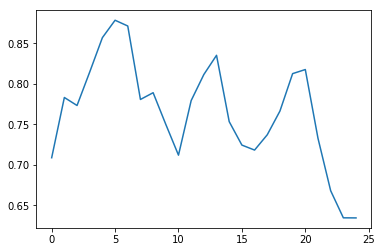

In [95]:
df4[['occupancy','pred_values_linear']].plot()

# It is basically a straight line that sort of captures the trend. 
# Not that great, let's try and improve that.

In [66]:
#**** REFINEMENT 1:ARIMA ***** 

# Now the key obvious issue with a linear regression here is that it is a line, like just a straight line
# while our data has an obvious cyclical feel to it (which makes sense for leisure activities). 
# Enter ARIMA. 

In [71]:
# I won't talk too much about the ARIMA part but the idea is that a SARIMA model is good for 
# series with trend and/or seasonal components.
# You need to enter the type of seasonality in your SARIMA, for instance quarterly seasonality would be 4. 
# The traditional way to do this is using autocorrelation but here we'll just use common sense and a look at the data plot.
# My gut feeling here is that we have weekly seasonality here with spikes during weekends, 
# so I am gonna give that guy a 7 as seasonal order.
# There is also a proper way to determine the coefficients of the ARIMA with information criteria 
# but I'll leave that for now and will give just (1,1,0).which means I am assuming a trend but no moving average
# ('cause it doesn't look like there are moving averages, which would show up as noisy movements around the trend) 

from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(y, order=(1, 1, 0), seasonal_order=(1, 1, 0, 1))
model_fit = model.fit(disp=False)

In [87]:
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                         occupancy   No. Observations:                   25
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 1)   Log Likelihood                  34.794
Date:                           Thu, 29 Nov 2018   AIC                            -63.587
Time:                                   17:47:09   BIC                            -60.181
Sample:                                        0   HQIC                           -62.731
                                            - 25                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1452      0.151     -0.959      0.338      -0.442       0.152
ar.S.L1       -0.1452      0.151     -0.959

In [91]:
# make prediction
yhat = model_fit.predict(1 , len(y))
print(yhat)

1     1.063158
2     0.857662
3     0.787426
4     0.842940
5     0.898200
6     0.906200
7     0.873162
8     0.714897
9     0.770453
10    0.722575
11    0.674632
12    0.816179
13    0.851836
14    0.862247
15    0.702268
16    0.682309
17    0.704357
18    0.748292
19    0.792230
20    0.853783
21    0.834397
22    0.674872
23    0.599318
24    0.591570
25    0.623976
dtype: float64


In [92]:
df4['pred_values_arima'] = yhat

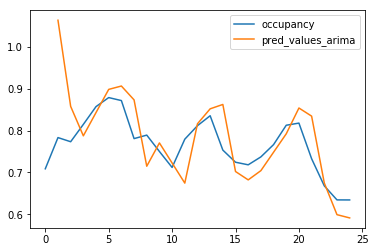

In [93]:
df4[['occupancy','pred_values_arima']].plot()

In [ ]:
#**** REFINEMENT 2:DEEP LEARNING ***** 